In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os

## Helper Functions

In [143]:
import os
import numpy as np
import pandas as pd
def get_admittance_data(path, time_col='ros_time_sec', norm_time_col=False):
    """
    This function retrieves the admittance data for
    both Monica and Ross from the specified path.

    @param path: The path to the directory containing the csv files.
    @param time_col: The name of the time column to use for merging.
    @param norm_time_col: Whether to normalize the time column
        (subtract each timestamp from the smallest timestamp).

    """
    monica_data = pd.read_csv(os.path.join(path, 'monica_admittance_data.csv'))
    ross_data = pd.read_csv(os.path.join(path, 'ross_admittance_data.csv'))

    # save everything to a single dataframe
    time_series_df = pd.merge(
        monica_data,
        ross_data,
        on=time_col,
        how='outer',
        # appends suffixes to the column names
        # from the original dataframes
        suffixes=('_monica', '_ross')
    ).sort_values(time_col).reset_index(drop=True)

    # fill in null values
    # time_series = time_series.set_index('time_sec')
    # time_series = time_series.interpolate(method='time').reset_index()
    time_series_df = time_series_df.interpolate(method='linear')
    # fill in NaN values
    time_series_df = time_series_df.bfill()

    # normalize time column
    if norm_time_col:
        time_series_df[time_col] = (time_series_df[time_col] - time_series_df[time_col].min()) / \
            (time_series_df[time_col].max() - time_series_df[time_col].min())

    return time_series_df

def merge_traj_and_admittance_data(
    traj_df, admittance_df,
    time_col='ros_time_sec', tolerance=0.01):
    """
    Merge the trajectory and admittance data on the time column.

    @param traj_df: The trajectory dataframe.
    @param admittance_df: The admittance dataframe.
    @return: The merged dataframe.
    """
    merged_df = pd.merge_asof(
        traj_df,
        admittance_df,
        on=time_col,
        direction='nearest',
        tolerance=tolerance
        # dataframes share no important columns
        # so this is unnecessary
        # suffixes=('_traj', '_admittance')
    )
    return merged_df


def get_stats(path, time_col='ros_time_sec', n_samples=100):
    """
    Retrieves and computes statistics from trajectory and admittance data across multiple trials.

    @param path: Directory containing trial subfolders.
    @param time_col: Name of the time column (should be normalized to [0, 1]).
    @param n_samples: Number of equally spaced samples to take per trial.
    @return: Dictionary with 'mean' and 'std' DataFrames, indexed by normalized_time.
    """
    columns_to_sample = [
        'act_ross_x', 'act_ross_y', 'act_mon_x', 'act_mon_y',
        'act_payload_x', 'act_payload_y', 'force_monica', 'force_ross'
    ]
    resampled_trials = []

    for trial in os.listdir(path):
        trial_path = os.path.join(path, trial)
        if not os.path.isdir(trial_path):
            continue

        try:
            traj_df = pd.read_csv(os.path.join(trial_path, 'trajectory_data.csv'))
            admittance_df = get_admittance_data(trial_path, time_col=time_col)
        except FileNotFoundError:
            print(f"Skipping trial {trial}: Required data files not found.")
            continue
        except Exception as e:
            print(f"Skipping trial {trial}: {e}")
            continue

        # Normalize time column for trajectory
        traj_df['normalized_time'] = (
            traj_df[time_col] - traj_df[time_col].min()
        ) / (traj_df[time_col].max() - traj_df[time_col].min())

        # Merge trajectory and admittance data
        merged_df = merge_traj_and_admittance_data(traj_df, admittance_df)

        # Create equally spaced normalized time grid
        sample_points = np.linspace(0, 1, n_samples)
        trial_samples = pd.DataFrame({'normalized_time': sample_points})

        # Interpolate each column to the common time grid
        for col in columns_to_sample:
            if col in merged_df.columns and 'normalized_time' in merged_df.columns:
                trial_samples[col] = np.interp(
                    sample_points,
                    merged_df['normalized_time'],
                    merged_df[col]
                )
            else:
                trial_samples[col] = np.nan  # Fill missing columns with NaN

        resampled_trials.append(trial_samples)

    # Combine all trials and compute statistics
    combined_df = pd.concat(resampled_trials, ignore_index=True)
    stats = {
        "mean": combined_df.groupby('normalized_time').mean(),
        "std": combined_df.groupby('normalized_time').std()
    }
    return stats

## Plotting Functions

In [144]:
def plot_traj_and_force(
        merged_df,
        time_col='ros_time_sec',
        fig_size=(18, 8),
        ross_color='blue',
        monica_color='red',
        payload_color='green',
        desired_line_style='-',
        actual_line_style='--'
    ):
    fig, axes = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=fig_size,
    )

    # plot trajectories
    axes[0].plot(
        merged_df['act_mon_x'],
        merged_df['act_mon_y'],
        label='Monica\'s actual trajectory',
        color=monica_color,
        linestyle=actual_line_style,
        markersize=6
    )
    axes[0].plot(
        merged_df['des_mon_x'],
        merged_df['des_mon_y'],
        label='Monica\'s desired trajectory',
        color=monica_color,
        linestyle=desired_line_style,
        markersize=6
    )
    axes[0].plot(
        merged_df['act_ross_x'],
        merged_df['act_ross_y'],
        label='Ross\'s actual trajectory',
        color=ross_color,
        linestyle=actual_line_style,
        markersize=6
    )
    axes[0].plot(
        merged_df['des_ross_x'],
        merged_df['des_ross_y'],
        label='Ross\'s desired trajectory',
        color=ross_color,
        linestyle=desired_line_style,
        markersize=6
    )
    axes[0].plot(
        merged_df['act_payload_x'],
        merged_df['act_payload_y'],
        label='Payload\'s actual trajectory',
        color=payload_color,
        linestyle=actual_line_style,
        markersize=6
    )
    axes[0].set_xlabel('X (m)')
    axes[0].set_ylabel('Y (m)')
    axes[0].set_title('Actual Trajectories')
    axes[0].legend()
    axes[0].grid(True)

    # plot forces
    axes[1].plot(
        merged_df['act_payload_x'],
        merged_df['force_monica'],
        label="Monica's force",
        color=monica_color
    )
    axes[1].plot(
        merged_df['act_payload_x'],
        merged_df['force_ross'],
        label="Ross's force",
        color=ross_color
    )
    axes[1].set_xlabel('Payload X Position (m)')
    axes[1].set_ylabel('Force (N)')
    axes[1].set_title('Force vs Payload X Position')
    axes[1].legend()
    axes[1].grid(True)

    fig.tight_layout()


def plot_stats(
        stats,
        fig_size=(18, 8),
        ross_color='blue',
        monica_color='red',
        payload_color='green'
    ):
    """
    Plots the mean and standard deviation of trajectory and force data over normalized time.

    @param stats: A dictionary containing 'mean' and 'std' DataFrames, indexed by normalized_time.
    """
    if stats is None or 'mean' not in stats or 'std' not in stats:
        print("Invalid stats dictionary provided. Cannot plot.")
        return

    mean_df = stats['mean']
    std_df = stats['std']

    fig, axes = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=fig_size,
    )

    # --- Trajectories ---
    axes[0].plot(
        mean_df['act_mon_x'],
        mean_df['act_mon_y'],
        label="Monica's mean trajectory",
        color=monica_color,
        linestyle='--',
        markersize=6
    )
    axes[0].fill_between(
        mean_df['act_mon_x'],
        mean_df['act_mon_y'] - std_df['act_mon_y'],
        mean_df['act_mon_y'] + std_df['act_mon_y'],
        color=monica_color,
        alpha=0.2,
        label="Monica's std dev"
    )
    axes[0].plot(
        mean_df['act_ross_x'],
        mean_df['act_ross_y'],
        label="Ross's mean trajectory",
        color=ross_color,
        linestyle='--',
        markersize=6
    )
    axes[0].fill_between(
        mean_df['act_ross_x'],
        mean_df['act_ross_y'] - std_df['act_ross_y'],
        mean_df['act_ross_y'] + std_df['act_ross_y'],
        color=ross_color,
        alpha=0.2,
        label="Ross's std dev"
    )
    axes[0].plot(
        mean_df['act_payload_x'],
        mean_df['act_payload_y'],
        label="Payload's mean trajectory",
        color=payload_color,
        linestyle='--',
        markersize=6
    )
    axes[0].fill_between(
        mean_df['act_payload_x'],
        mean_df['act_payload_y'] - std_df['act_payload_y'],
        mean_df['act_payload_y'] + std_df['act_payload_y'],
        color=payload_color,
        alpha=0.2,
        label="Payload's std dev"
    )
    axes[0].set_xlabel('X (m)')
    axes[0].set_ylabel('Y (m)')
    axes[0].set_title('Mean Trajectories with Std. Dev.')
    axes[0].legend()
    axes[0].grid(True)

    # --- Forces ---
    axes[1].plot(
        mean_df['act_payload_x'],
        mean_df['force_monica'],
        label="Monica's mean force",
        color=monica_color
    )
    axes[1].fill_between(
        mean_df['act_payload_x'],
        mean_df['force_monica'] - std_df['force_monica'],
        mean_df['force_monica'] + std_df['force_monica'],
        color=monica_color,
        alpha=0.2,
        label="Monica's force std dev"
    )
    axes[1].plot(
        mean_df['act_payload_x'],
        mean_df['force_ross'],
        label="Ross's mean force",
        color=ross_color
    )
    axes[1].fill_between(
        mean_df['act_payload_x'],
        mean_df['force_ross'] - std_df['force_ross'],
        mean_df['force_ross'] + std_df['force_ross'],
        color=ross_color,
        alpha=0.2,
        label="Ross's force std dev"
    )
    axes[1].set_xlabel('Payload X Position (m)')
    axes[1].set_ylabel('Force (N)')
    axes[1].set_title('Mean Forces with Std. Dev.')
    axes[1].legend()
    axes[1].grid(True)

    fig.tight_layout()

## Plotting / Data Analysis

In [145]:
csv_path = '../../data/08-30_dataset/08-30_a_experiments/08-30_a_trial_01/'
time_col = 'ros_time_sec'
norm_time_col = True

traj_df = pd.read_csv(csv_path + 'trajectory_data.csv')

# normalize time column
if norm_time_col:
    traj_df[time_col] = (traj_df[time_col] - traj_df[time_col].min()) / (traj_df[time_col].max() - traj_df[time_col].min())

traj_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1501 entries, 0 to 1500
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   des_ross_x                1501 non-null   float64
 1   des_ross_y                1501 non-null   float64
 2   des_ross_theta            1501 non-null   float64
 3   des_mon_x                 1501 non-null   float64
 4   des_mon_y                 1501 non-null   float64
 5   des_mon_theta             1501 non-null   float64
 6   act_ross_x                1501 non-null   float64
 7   act_ross_y                1501 non-null   float64
 8   act_ross_theta            1501 non-null   float64
 9   act_mon_x                 1501 non-null   float64
 10  act_mon_y                 1501 non-null   float64
 11  act_mon_theta             1501 non-null   float64
 12  act_payload_x             1501 non-null   float64
 13  act_payload_y             1501 non-null   float64
 14  act_payl

In [146]:
admittance_df = get_admittance_data(csv_path, time_col=time_col, norm_time_col=norm_time_col)

admittance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67700 entries, 0 to 67699
Data columns (total 35 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   t_p_x_monica        67700 non-null  float64
 1   t_p_y_monica        67700 non-null  float64
 2   t_p_z_monica        67700 non-null  float64
 3   t_w_monica          67700 non-null  float64
 4   t_x_monica          67700 non-null  float64
 5   t_y_monica          67700 non-null  float64
 6   t_z_monica          67700 non-null  float64
 7   v_p_x_monica        67700 non-null  float64
 8   v_p_y_monica        67700 non-null  float64
 9   v_p_z_monica        67700 non-null  float64
 10  v_w_monica          67700 non-null  float64
 11  v_x_monica          67700 non-null  float64
 12  v_y_monica          67700 non-null  float64
 13  v_z_monica          67700 non-null  float64
 14  force_monica        67700 non-null  float64
 15  stiffness_monica    67700 non-null  float64
 16  ros_

In [147]:
merged_df = merge_traj_and_admittance_data(
    traj_df,
    admittance_df,
    time_col=time_col,
    tolerance=None
)

merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1501 entries, 0 to 1500
Data columns (total 56 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   des_ross_x                1501 non-null   float64
 1   des_ross_y                1501 non-null   float64
 2   des_ross_theta            1501 non-null   float64
 3   des_mon_x                 1501 non-null   float64
 4   des_mon_y                 1501 non-null   float64
 5   des_mon_theta             1501 non-null   float64
 6   act_ross_x                1501 non-null   float64
 7   act_ross_y                1501 non-null   float64
 8   act_ross_theta            1501 non-null   float64
 9   act_mon_x                 1501 non-null   float64
 10  act_mon_y                 1501 non-null   float64
 11  act_mon_theta             1501 non-null   float64
 12  act_payload_x             1501 non-null   float64
 13  act_payload_y             1501 non-null   float64
 14  act_payl

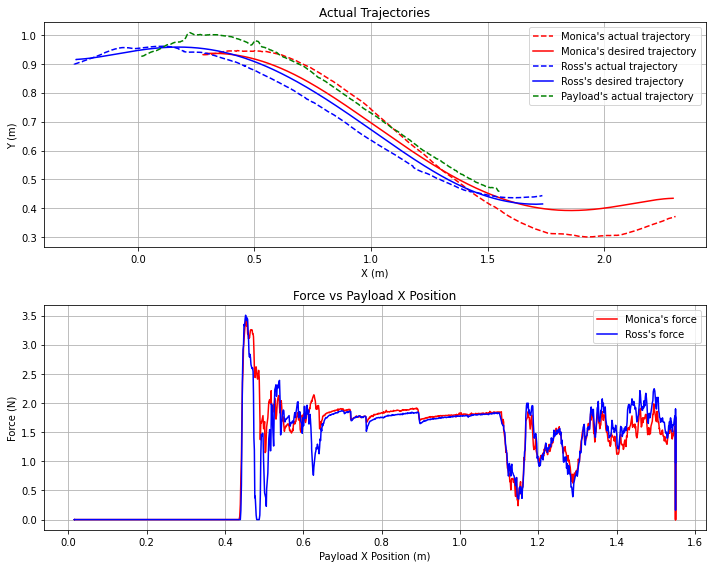

In [148]:
plot_traj_and_force(merged_df, fig_size=(10, 8))

In [149]:
stats = get_stats('../../data/08-30_dataset/08-30_dp_experiments/', time_col=time_col, n_samples=100)

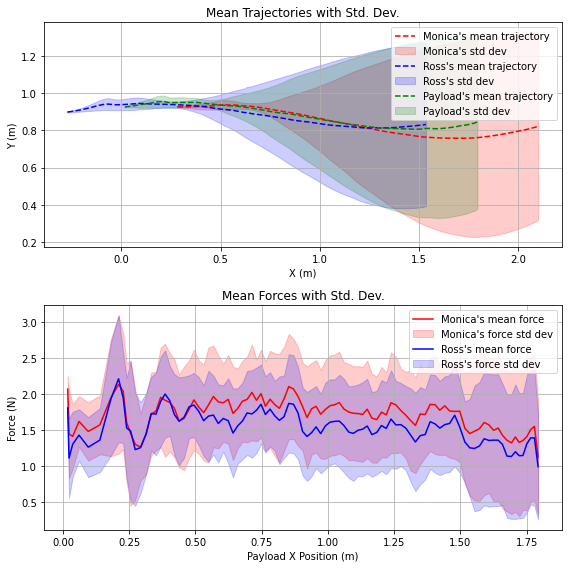

In [150]:
plot_stats(stats, fig_size=(8, 8))